In [2]:
import pandas as pd
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import preprocess as datapre

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import log_loss, make_scorer, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

importlib.reload(datapre)

<module 'preprocess' from 'D:\\GitHub\\MachineLearning\\capstone\\solutions\\preprocess.py'>

## 1 数据探索
来自于Kaggle名为旧金山罪案类型分类的数据集，该数据集分为训练集和测试集，训练集包含878049个带标签样本，测试集包含884262个未带标签样本。  
运行下边代码加载训练集和测试集。

In [3]:
origin_train_data = pd.read_csv('../datasets/train.csv', parse_dates=['Dates'])
test_data = pd.read_csv('../datasets/test.csv', parse_dates=['Dates'])

### 1.1 显示数据集部分样本

In [4]:
origin_train_data.head(1)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [5]:
test_data.head(1)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051


### 1.2 删除训练集中无用字段
训练集中的'Descript'，'Resolution'两个属性无意义，直接删除

In [6]:
# 删除无用字段 'Descript' 'Resolution'
origin_train_data = origin_train_data.drop(columns=['Descript', 'Resolution'])

### 1.3 处理数据集中的缺失值

In [7]:
print((origin_train_data.isnull().any(axis=0) == False).all())
print((origin_train_data.isna().any(axis=0) == False).all())

True
True


**确定训练集中没有缺失数据。**

### 1.4 特征提取

#### 1.4.1 Dates解析为年月日时

In [8]:
origin_train_data = datapre.extra_dates(origin_train_data)

#### 1.4.2 DayOfWeek转化为数字

In [9]:
DayOfWeekEnc = LabelEncoder()
origin_train_data['DayOfWeekID'] = DayOfWeekEnc.fit_transform(origin_train_data['DayOfWeek'])

#### 1.4.3 PdDistrict转化为数字

In [10]:
PdDistrictEnc = LabelEncoder()
origin_train_data['PdDistrictID'] = PdDistrictEnc.fit_transform(origin_train_data['PdDistrict'])

#### 1.4.4 从Address中提取是否含有Block字段作为特征

In [11]:
origin_train_data = datapre.extra_address_for_block(origin_train_data)

#### 1.4.5 从Address中提取地址后缀作为特征
- 标准的地址都会含有一个简写后缀表示道路的类型，直接解析后缀，如："200 Block of INTERSTATE80 HY"解析为"HY"。
- 对于路口则会表示成'XX ST / YY ST'，直接解析为"CrossRoad"，如："STCHARLES AV / 19TH AV"解析为"CrossRoad"。
- 对于直接含有道路类型全名的地址也要进行解析。如："0 Block of AVENUE OF THE PALMS"中的"AVENUE"就是道路类型。
- 对于上述三种方式都无法解析，则直接设置为"Unkown"。  

根据直觉判断，不同类型的道路发生各种类型犯罪的分布是不一样的。如：铁路附近发生自杀案件的概率普遍高于其他案件。

In [12]:
origin_train_data = datapre.extra_address_for_suffix(origin_train_data)

#### 1.4.6 从Address中提取道路名称作为特征

In [13]:
origin_train_data = datapre.extra_address_for_infos(origin_train_data)

There is only one road name in CrossRoad. index:  [173430, 217606, 285516, 350752, 410727, 460380, 526746, 528049, 535469, 673078, 677260, 677268, 683862, 741420, 755445, 756059, 763376, 769674, 769675, 772415, 780968, 787517, 787770, 804816, 804817, 811431, 828322, 828766, 830042, 834617, 834621, 843892, 843893, 870171, 870173, 875737, 877289, 877361]


#### 1.4.7 将RoadType、RoadBlock、RoadName1、RoadName2转化为ID

In [14]:
RoadTypeEnc, RoadBlockEnc, RoadName1Enc, RoadName2Enc = LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder()
origin_train_data['RoadTypeID'] = RoadTypeEnc.fit_transform(origin_train_data['RoadType'])
origin_train_data["RoadBlockID"] = RoadBlockEnc.fit_transform(origin_train_data["RoadBlock"])
origin_train_data["RoadName1ID"] = RoadName1Enc.fit_transform(origin_train_data["RoadName1"])
origin_train_data["RoadName2ID"] = RoadName2Enc.fit_transform(origin_train_data["RoadName2"])

In [15]:
origin_train_data.head(1)

,Dates,Category,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,...,PdDistrictID,HasBlock,RoadType,RoadName1,RoadName2,RoadBlock,RoadTypeID,RoadBlockID,RoadName1ID,RoadName2ID
0,2015-05-13 23:53:00,WARRANTS,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,...,4,0,CrossRoad,OAK,LAGUNA,Unkown,5,84,1296,842


#### 1.4.8 保存预处理后的训练集

In [16]:
origin_train_data.to_csv("../datasets/train_preprocess.csv", index=False)

#### 1.4.9 测试集数据预处理

In [17]:
# Dates处理
test_data = datapre.extra_dates(test_data)
test_data['DayOfWeekID'] = DayOfWeekEnc.transform(test_data['DayOfWeek'])

# PdDistrict装换成数字编码
test_data['PdDistrictID'] = PdDistrictEnc.transform(test_data['PdDistrict'])

# HasBlock字段
test_data = datapre.extra_address_for_block(test_data)

# Address道路类型解析
test_data = datapre.extra_address_for_suffix(test_data)
test_data['RoadTypeID'] = RoadTypeEnc.fit_transform(test_data['RoadType'])

# Address道路名称、道路编号解析
test_data = datapre.extra_address_for_infos(test_data)

# 训练集中没有的道路名称或者编号都设置为Unkown
test_data.loc[test_data["RoadBlock"].isin(RoadBlockEnc.classes_) == False, "RoadBlock"] = "Unkown"
test_data.loc[test_data["RoadName1"].isin(RoadName1Enc.classes_) == False, "RoadName1"] = "Unkown"
test_data.loc[test_data["RoadName2"].isin(RoadName2Enc.classes_) == False, "RoadName2"] = "Unkown"

# 字符串装换为数字编码
test_data["RoadBlockID"] = RoadBlockEnc.transform(test_data["RoadBlock"])
test_data["RoadName1ID"] = RoadName1Enc.transform(test_data["RoadName1"])
test_data["RoadName2ID"] = RoadName2Enc.transform(test_data["RoadName2"])

There is only one road name in CrossRoad. index:  [61142, 81880, 110373, 110374, 111915, 111916, 310541, 318229, 352785, 356388, 376672, 471894, 493647, 530783, 535977, 540605, 540639, 664826, 667226, 750255, 770149, 770150, 773771, 773778, 778414, 784851, 796864, 800668, 800670, 823027, 848799, 848892, 858836, 858837, 859378, 859379, 859380, 865755, 873429]


#### 1.4.10 保存预处理后的测试集

In [18]:
test_data.to_csv("../datasets/test_preprocess.csv", index=False)

#### 1.4.11 设置训练模型特征名字

In [19]:
feature_names = ['Year', 'Month', 'Hour', 'DayOfWeekID', 'PdDistrictID', \
                 'HasBlock', 'RoadTypeID', 'RoadBlockID', 'RoadName1ID', 'RoadName2ID', 'X', 'Y']

#### 1.4.12 训练数据可视化
在文件"data_visualization.ipynb"中展示

## 2 模型训练与调参
选用两个模型进行训练和调参。
- 随机森林
- XGBoostClassifier梯度提升树

### 2.1 基础模型
首先对两个模型进行经典参数训练，确定一个调参的基线。

In [21]:
valid_X = test_data[feature_names]

#### 2.1.1 随机森林基线训练

In [31]:
total_X = origin_train_data[feature_names]
totalTargetEnc = LabelEncoder()
total_y_true = totalTargetEnc.fit_transform(origin_data["Category"])

# 创建模型
base_rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    min_samples_split=20,
    max_features=0.8, 
    n_jobs=-1, random_state=42)

# 训练模型
base_rf_clf.fit(total_X, total_y_true)

# 预测测试集
y_pred_prob_base = np.round(base_rf_clf.predict_proba(valid_X), 4)

# 预测结果按指定格式保存文件
csv_output = pd.DataFrame(columns=TargetEnc.classes_, data=y_pred_prob)
csv_output.insert(0, 'Id', valid_data['Id'])
csv_output.to_csv('../results/RandomForestClf_base.csv', index=False)

#### 2.1.2 XGBClassifier基线训练

In [ ]:
base_X = origin_train_data[feature_names]
base_y_true =origin_train_data["Category"]

base_xgbclf = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.5,
    colsample_bytree=0.5,
    gamma=0.2,
    n_jobs=-1,
    random_state=42
    )

base_xgbclf.fit(base_X, base_y_true,
                eval_set=[(base_X, base_y_true)],
                eval_metric="mlogloss",
                verbose=True)

base_y_pred_prob = np.round(base_xgbclf.predict_proba(valid_X), 4)
csv_output = pd.DataFrame(columns=base_xgbclf.classes_, data=base_y_pred_prob)
csv_output.insert(0, 'Id', valid_data['Id'])
csv_output.to_csv('../results/XGBClassifier_base.csv', index=False)

[0]	validation_0-mlogloss:3.4734
[1]	validation_0-mlogloss:3.34404
[2]	validation_0-mlogloss:3.24319
[3]	validation_0-mlogloss:3.16024
[4]	validation_0-mlogloss:3.09035
[5]	validation_0-mlogloss:3.03031
[6]	validation_0-mlogloss:2.97736
[7]	validation_0-mlogloss:2.92991
[8]	validation_0-mlogloss:2.88951
[9]	validation_0-mlogloss:2.85297
[10]	validation_0-mlogloss:2.81952
[11]	validation_0-mlogloss:2.78938
[12]	validation_0-mlogloss:2.7613
[13]	validation_0-mlogloss:2.73599
[14]	validation_0-mlogloss:2.71362
[15]	validation_0-mlogloss:2.69247
[16]	validation_0-mlogloss:2.67257
[17]	validation_0-mlogloss:2.65476
[18]	validation_0-mlogloss:2.63826
[19]	validation_0-mlogloss:2.62341
[20]	validation_0-mlogloss:2.60929
[21]	validation_0-mlogloss:2.596
[22]	validation_0-mlogloss:2.58357
[23]	validation_0-mlogloss:2.57197
[24]	validation_0-mlogloss:2.56103
[25]	validation_0-mlogloss:2.55101
[26]	validation_0-mlogloss:2.54132
[27]	validation_0-mlogloss:2.53243
[28]	validation_0-mlogloss:2.52452

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=-1, nthread=None,
       objective='multi:softprob', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5)

### 2.2 网格搜索

scikit-learn包中的网格搜索函数`GridSearchCV`是寻找得分函数的极大值，因此需要对对数分数取反作为模型的得分。

In [22]:
# 定义网格搜索使用的得分函数
# 多分类对数损失函数取反
def neg_log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None):
    return -log_loss(y_true, y_pred, eps, normalize, sample_weight, labels)

call_neg_log_loss = make_scorer(neg_log_loss, needs_proba=True)

#### 2.2.1 随机森林

In [23]:
# 设置基础参数，在这组参数的基础上进行逐个调参
base_params = dict(n_estimators=300, max_depth=5, min_samples_split=20,
                    max_features=0.5, n_jobs=-1, random_state=42)

为了将时间控制在合理范围内，网格搜索仅使用部分训练集中的样本

In [24]:
train_data = datapre.dataset_sample(origin_train_data, frac=0.5)

X = train_data[feature_names]
y_true = train_data["Category"]

# 将目标类别编码为数字
TargetEnc = LabelEncoder()
y_true = TargetEnc.fit_transform(y_true)

`criterion`调优

In [10]:
param_grid = {"criterion": ["gini", "entropy"]}

rfclf = RandomForestClassifier(**base_params)
cv_clf_criterion = GridSearchCV(estimator=rfclf, param_grid=param_grid, 
                                scoring=call_neg_log_loss, 
                                n_jobs=-1, cv=5, verbose=4, return_train_score=True, refit=False)

start = time.time()
cv_clf_criterion.fit(X, y_true)
print("Training needs %d seconds." % (time.time()-start))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  9.6min remaining: 14.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 10.7min remaining:  4.6min


Training needs 787 seconds.


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 13.1min finished


In [11]:
cv_clf_criterion.best_params_

{'criterion': 'entropy'}

In [12]:
cv_clf_criterion.cv_results_

{'mean_fit_time': array([377.62422113, 360.51584072]),
 'std_fit_time': array([  1.95029143, 163.90649584]),
 'mean_score_time': array([37.51303835, 28.0612236 ]),
 'std_score_time': array([ 0.62397431, 14.37338393]),
 'param_criterion': masked_array(data=['gini', 'entropy'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini'}, {'criterion': 'entropy'}],
 'split0_test_score': array([-2.52907413, -2.52679097]),
 'split1_test_score': array([-2.52407811, -2.52206075]),
 'split2_test_score': array([-2.52470506, -2.52167583]),
 'split3_test_score': array([-2.52755128, -2.52481451]),
 'split4_test_score': array([-2.52662738, -2.52489309]),
 'mean_test_score': array([-2.5264072 , -2.52404703]),
 'std_test_score': array([0.00183268, 0.00191851]),
 'rank_test_score': array([2, 1]),
 'split0_train_score': array([-2.52244801, -2.51980186]),
 'split1_train_score': array([-2.52358955, -2.5211375 ]),
 'split2_train_score': array([-

`min_samples_split`调优

In [13]:
param_grid = {"min_samples_split": list(range(20, 101, 20))}

base_params["criterion"] = cv_clf_criterion.best_params_["criterion"]
rfclf = RandomForestClassifier(**base_params)
cv_clf_min_samples_split = GridSearchCV(estimator=rfclf, param_grid=param_grid, 
                                scoring=call_neg_log_loss, 
                                n_jobs=-1, cv=5, verbose=4, return_train_score=True, refit=False)

start = time.time()
cv_clf_min_samples_split.fit(X, y_true)
print("Training needs %d seconds." % (time.time()-start))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed: 33.4min remaining: 15.7min


Training needs 2095 seconds.


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 34.9min finished


In [ ]:
cv_clf_min_samples_split.best_params_

{'min_samples_split': 60}

In [ ]:
cv_clf_min_samples_split.cv_results_

{'mean_fit_time': array([464.73708339, 464.26790142, 464.3276195 , 463.22402234,
        386.73499465]),
 'std_fit_time': array([  1.41639691,   1.40555434,   0.32925884,   1.34880926,
        163.42989577]),
 'mean_score_time': array([39.81927314, 40.5610456 , 41.66956849, 40.11531024, 32.93259096]),
 'std_score_time': array([ 0.49060337,  0.98599894,  0.5183828 ,  0.6906298 , 13.53346669]),
 'param_min_samples_split': masked_array(data=[20, 40, 60, 80, 100],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_split': 20},
  {'min_samples_split': 40},
  {'min_samples_split': 60},
  {'min_samples_split': 80},
  {'min_samples_split': 100}],
 'split0_test_score': array([-2.52679097, -2.52679097, -2.52679163, -2.52678297, -2.52681774]),
 'split1_test_score': array([-2.52206075, -2.52206075, -2.52206089, -2.52206541, -2.52205331]),
 'split2_test_score': array([-2.52167583, -2.52167583, -2.52165876, -2.5216590

`max_features`调优

In [ ]:
param_grid = {"max_features": [round(i*0.1,1) for i in range(5, 11)]}

base_params["min_samples_split"] = cv_clf_min_samples_split.best_params_["min_samples_split"]
rfclf = RandomForestClassifier(**base_params)
cv_clf_max_features = GridSearchCV(estimator=rfclf, param_grid=param_grid, 
                                scoring=call_neg_log_loss, 
                                n_jobs=-1, cv=5, verbose=4, return_train_score=True, refit=False)

start = time.time()
cv_clf_max_features.fit(X, y_true)
print("Training with total dataset needs %d seconds." % (time.time()-start))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 39.2min remaining: 11.9min


Training with total dataset needs 3045 seconds.


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 50.8min finished


In [ ]:
cv_clf_max_features.best_params_

{'max_features': 0.6}

In [ ]:
cv_clf_max_features.cv_results_

{'mean_fit_time': array([466.10893898, 521.05996537, 577.37079701, 625.0942153 ,
        658.65490699, 615.98455191]),
 'std_fit_time': array([ 0.58864978,  0.66178994,  1.96446675,  5.61541478, 48.3168318 ,
        14.03208936]),
 'mean_score_time': array([36.83551712, 39.84070601, 37.56637659, 47.3072475 , 34.50676036,
        24.62801032]),
 'std_score_time': array([ 0.63427667,  0.72726104,  0.53699966, 11.69145063,  1.60775988,
         4.52784121]),
 'param_max_features': masked_array(data=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 0.5},
  {'max_features': 0.6},
  {'max_features': 0.7},
  {'max_features': 0.8},
  {'max_features': 0.9},
  {'max_features': 1.0}],
 'split0_test_score': array([-2.52679163, -2.52679075, -2.52811846, -2.53081133, -2.53307424,
        -2.54405006]),
 'split1_test_score': array([-2.52206089, -2.52156219, -2.52255916, -2.525

`bootstrap`调优

In [ ]:
param_grid = {"bootstrap": [True, False]}

base_params["max_features"] = cv_clf_max_features.best_params_["max_features"]
rfclf = RandomForestClassifier(**base_params)
cv_clf_bootstrap = GridSearchCV(estimator=rfclf, param_grid=param_grid, 
                                scoring=call_neg_log_loss, 
                                n_jobs=-1, cv=5, verbose=4, return_train_score=True, refit=False)

start = time.time()
cv_clf_bootstrap.fit(X, y_true)
print("Training needs %d seconds." % (time.time()-start))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed: 11.9min remaining: 17.8min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 12.5min remaining:  5.4min


Training needs 930 seconds.


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 15.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 15.5min finished


In [ ]:
cv_clf_bootstrap.best_params_

{'bootstrap': True}

In [ ]:
cv_clf_bootstrap.cv_results_

{'mean_fit_time': array([514.41487279, 414.07483211]),
 'std_fit_time': array([  1.22824183, 202.95871421]),
 'mean_score_time': array([36.44589915, 27.05701218]),
 'std_score_time': array([ 0.24104818, 13.63592581]),
 'param_bootstrap': masked_array(data=[True, False],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'bootstrap': True}, {'bootstrap': False}],
 'split0_test_score': array([-2.52679075, -2.5273457 ]),
 'split1_test_score': array([-2.52156219, -2.52226348]),
 'split2_test_score': array([-2.52140237, -2.52196708]),
 'split3_test_score': array([-2.52458029, -2.52528339]),
 'split4_test_score': array([-2.52425029, -2.52514066]),
 'mean_test_score': array([-2.5237172 , -2.52440007]),
 'std_test_score': array([0.00202387, 0.00202444]),
 'rank_test_score': array([1, 2]),
 'split0_train_score': array([-2.5195774 , -2.52015829]),
 'split1_train_score': array([-2.52060323, -2.52144707]),
 'split2_train_score': array([-2.52075189, 

使用整个训练集进行网格搜索交叉验证找到n_estimators和max_depth的最优值，并得到最优模型。  
**寻找这两个组合的代码在jupyter中运行总是挂死，因此是在脚本中执行的，这里没有打印信息。**

In [12]:
total_X = origin_train_data[feature_names]
total_y_true = origin_train_data["Category"]

totalTargetEnc = LabelEncoder()
total_y_true = totalTargetEnc.fit_transform(total_y_true)

In [ ]:
param_grid = {"n_estimators": list(range(1000, 2001, 500))，
              "max_depth": [5, 8, 10]}

base_params["bootstrap"] = cv_clf_bootstrap.best_params_["bootstrap"]
rfclf = RandomForestClassifier(**base_params)
cv_clf_final = GridSearchCV(estimator=rfclf, param_grid=param_grid, 
                                scoring=call_neg_log_loss, 
                                n_jobs=-1, cv=5, verbose=4, return_train_score=True, refit=True)

start = time.time()
cv_clf_final.fit(total_X, total_y_true)
print("Training needs %d seconds." % (time.time()-start))

In [ ]:
cv_clf_final.best_params_

In [ ]:
cv_clf_final.cv_results_

In [ ]:
base_params["n_estimators"]=cv_clf_final.best_params_["n_estimators"]
base_params["max_depth"] = cv_clf_final.best_params_["max_depth"]
print(base_params)

In [ ]:
best_rf_clf = cv_clf_final.best_estimator_

y_pred_prob = np.round(best_rf_clf.predict_proba(valid_X), 4)
csv_output = pd.DataFrame(columns=totalTargetEnc.classes_, data=y_pred_prob)
csv_output.insert(0, 'Id', valid_data['Id'])
csv_output.to_csv('../results/RandomForestClf_best.csv', index=False)

#### 2.2.2 XGBClassifier网格搜索调参

In [6]:
train_data = datapre.dataset_sample(origin_train_data, frac=0.05)

X = train_data[feature_names]
y_true = train_data["Category"]

In [26]:
base_params = dict(max_depth=6, learning_rate=0.1, n_estimators=1000, objective="multi:softprob",
                   n_jobs=8, gamma=0.3, min_child_weight=5, subsample=0.5, colsample_bytree=0.5, 
                   random_state=10)

`max_depth`调优

In [13]:
param_grid = {"max_depth": list(range(5,11))}

xgbclf = xgb.XGBClassifier(**base_params)
cv_clf_max_depth = GridSearchCV(estimator=xgbclf, 
                                  param_grid = param_grid,
                                  scoring = call_neg_log_loss, n_jobs=-1,
                                  cv=5, verbose=4, return_train_score=True, refit=False)

from time import time
start = time()
cv_clf_max_depth.fit(X, y_true)
print("Training elapse %d sencond." % (time()-start))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 53.7min remaining: 16.3min


Training elapse 4311 sencond.


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 71.9min finished


In [14]:
cv_clf_max_depth.best_params_

{'max_depth': 5}

In [15]:
cv_clf_max_depth.cv_results_

{'mean_fit_time': array([626.19248233, 702.92684155, 769.43168325, 828.9511951 ,
        875.59429774, 842.25797238]),
 'std_fit_time': array([ 3.45494354,  2.82458215,  5.74190074,  2.62147023, 28.06416944,
         9.61565067]),
 'mean_score_time': array([47.0621099 , 52.13231273, 55.64878421, 55.9638371 , 60.83959661,
        58.87585282]),
 'std_score_time': array([0.09338096, 4.88887037, 1.73601142, 3.34069386, 4.68284527,
        1.80940752]),
 'param_max_depth': masked_array(data=[5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}],
 'split0_test_score': array([-2.50880498, -2.52965947, -2.56193835, -2.59330729, -2.6279933 ,
        -2.65627778]),
 'split1_test_score': array([-2.52031923, -2.54994375, -2.58666441, -2.62619213, -2.65724265,
        -2.69486221]),
 'spli

`subsample`调优

In [16]:
param_grid = {"subsample": [i/10.0 for i in range(5,11)]}

base_params["max_depth"] = cv_clf_max_depth.best_params_["max_depth"]
xgbclf = xgb.XGBClassifier(**base_params)
cv_clf_subsample = GridSearchCV(estimator=xgbclf, 
                                  param_grid = param_grid,
                                  scoring = call_neg_log_loss, n_jobs=-1,
                                  cv=5, verbose=4, return_train_score=True, refit=False)

from time import time
start = time()
cv_clf_subsample.fit(X, y_true)
print("Training elapse %d sencond." % (time()-start))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 44.4min remaining: 13.5min


Training elapse 3391 sencond.


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 56.5min finished


In [17]:
cv_clf_subsample.best_params_

{'subsample': 1.0}

In [18]:
cv_clf_subsample.cv_results_

{'mean_fit_time': array([627.3380919 , 640.1003655 , 636.48946977, 618.588555  ,
        587.57899246, 464.12498069]),
 'std_fit_time': array([ 1.56979833,  1.20545202,  3.20307576,  4.84241038, 34.82023552,
         1.24286883]),
 'mean_score_time': array([49.89434581, 51.53903599, 51.74610453, 51.9848238 , 51.16554165,
        44.8976038 ]),
 'std_score_time': array([0.30745812, 0.30386716, 1.07445005, 0.55010802, 1.91373078,
        0.18291945]),
 'param_subsample': masked_array(data=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'subsample': 0.5},
  {'subsample': 0.6},
  {'subsample': 0.7},
  {'subsample': 0.8},
  {'subsample': 0.9},
  {'subsample': 1.0}],
 'split0_test_score': array([-2.50880498, -2.5084495 , -2.50513324, -2.50563333, -2.50351309,
        -2.5011439 ]),
 'split1_test_score': array([-2.52031923, -2.52289024, -2.52167484, -2.52212255, -2.51814985,
       

`colsample_bytree`调优

In [19]:
param_grid = {"colsample_bytree": [i/10.0 for i in range(5,11)]}

base_params["subsample"] = cv_clf_subsample.best_params_["subsample"]
xgbclf = xgb.XGBClassifier(**base_params)
cv_clf_colsample_bytree = GridSearchCV(estimator=xgbclf, 
                                  param_grid = param_grid,
                                  scoring = call_neg_log_loss, n_jobs=-1,
                                  cv=5, verbose=4, return_train_score=True, refit=False)

from time import time
start = time()
cv_clf_colsample_bytree.fit(X, y_true)
print("Training elapse %d sencond." % (time()-start))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 44.9min remaining: 13.7min


Training elapse 3567 sencond.


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 59.5min finished


In [20]:
cv_clf_colsample_bytree.best_params_

{'colsample_bytree': 0.5}

In [21]:
cv_clf_colsample_bytree.cv_results_

{'mean_fit_time': array([550.31487417, 592.83387299, 637.61420302, 676.87519708,
        704.27644124, 685.7923378 ]),
 'std_fit_time': array([ 1.66238957,  2.82515991,  1.85659911,  3.49916238, 34.46894857,
         7.15058799]),
 'mean_score_time': array([47.59789696, 48.41070781, 48.6649641 , 46.02194614, 47.89022465,
        43.20287366]),
 'std_score_time': array([0.28487682, 3.85917526, 1.27288079, 2.93536516, 4.65367396,
        1.56842069]),
 'param_colsample_bytree': masked_array(data=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'colsample_bytree': 0.5},
  {'colsample_bytree': 0.6},
  {'colsample_bytree': 0.7},
  {'colsample_bytree': 0.8},
  {'colsample_bytree': 0.9},
  {'colsample_bytree': 1.0}],
 'split0_test_score': array([-2.5011439 , -2.50372545, -2.50824547, -2.51176005, -2.51685107,
        -2.52096143]),
 'split1_test_score': array([-2.51336366, -2.5153409

`gamma`调优

In [22]:
param_grid = {"gamma": [i/10.0 for i in range(1,6)]}

base_params["colsample_bytree"] = cv_clf_colsample_bytree.best_params_["colsample_bytree"]
xgbclf = xgb.XGBClassifier(**base_params)
cv_clf_gamma = GridSearchCV(estimator=xgbclf, 
                                  param_grid = param_grid,
                                  scoring = call_neg_log_loss, n_jobs=-1,
                                  cv=5, verbose=4, return_train_score=True, refit=False)

from time import time
start = time()
cv_clf_gamma.fit(X, y_true)
print("Training elapse %d sencond." % (time()-start))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed: 40.6min remaining: 19.1min


Training elapse 2943 sencond.


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 49.1min finished


In [23]:
cv_clf_gamma.best_params_

{'gamma': 0.5}

In [24]:
cv_clf_gamma.cv_results_

{'mean_fit_time': array([551.24358735, 554.29367762, 563.41414204, 554.31911249,
        510.53647475]),
 'std_fit_time': array([ 2.77376359,  6.0755266 ,  5.4145506 ,  5.91920237, 85.68212822]),
 'mean_score_time': array([51.92375593, 51.48269906, 52.5986012 , 50.23768287, 46.97435017]),
 'std_score_time': array([0.47365801, 0.428969  , 0.92783886, 1.34428278, 7.30802904]),
 'param_gamma': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0.1},
  {'gamma': 0.2},
  {'gamma': 0.3},
  {'gamma': 0.4},
  {'gamma': 0.5}],
 'split0_test_score': array([-2.50153481, -2.49949787, -2.5011439 , -2.49878625, -2.49698049]),
 'split1_test_score': array([-2.51486742, -2.51499955, -2.51336366, -2.51024172, -2.50924856]),
 'split2_test_score': array([-2.49890718, -2.49638023, -2.4973559 , -2.4928639 , -2.49138574]),
 'split3_test_score': array([-2.50295881, -2.50292551, -2.503922

`min_child_weight`调优

In [25]:
param_grid = {"min_child_weight": list(range(4,10))}

base_params["gamma"] = cv_clf_gamma.best_params_["gamma"]
xgbclf = xgb.XGBClassifier(**base_params)
cv_clf_min_child_weight = GridSearchCV(estimator=xgbclf, 
                                  param_grid = param_grid,
                                  scoring = call_neg_log_loss, n_jobs=-1,
                                  cv=5, verbose=4, return_train_score=True, refit=False)

from time import time
start = time()
cv_clf_min_child_weight.fit(X, y_true)
print("Training elapse %d sencond." % (time()-start))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 40.0min remaining: 12.2min


Training elapse 3072 sencond.


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 51.2min finished


In [26]:
cv_clf_min_child_weight.best_params_

{'min_child_weight': 9}

In [27]:
cv_clf_min_child_weight.cv_results_

{'mean_fit_time': array([557.10483918, 549.70378079, 546.94308958, 541.70458159,
        521.92100205, 456.36973176]),
 'std_fit_time': array([ 3.436357  ,  1.39122553,  2.40576659,  1.59643441, 31.73576629,
         2.40518425]),
 'mean_score_time': array([51.47318053, 49.99020824, 50.26187272, 49.3864233 , 47.68853731,
        43.23817577]),
 'std_score_time': array([0.36121709, 0.30604972, 0.29297429, 0.31949911, 1.95143244,
        0.29821205]),
 'param_min_child_weight': masked_array(data=[4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_child_weight': 4},
  {'min_child_weight': 5},
  {'min_child_weight': 6},
  {'min_child_weight': 7},
  {'min_child_weight': 8},
  {'min_child_weight': 9}],
 'split0_test_score': array([-2.49869243, -2.49698049, -2.49290738, -2.49160397, -2.48774096,
        -2.48711578]),
 'split1_test_score': array([-2.51212317, -2.50924856, -2.50576084, -2.50417

使用上面找到的最优参数，并减小学习率为0.01，使用整个训练集训练一个超复杂模型，暂定训练5000棵树。

In [6]:
X = origin_train_data[feature_names]

TargetEnc = LabelEncoder()
y_true = TargetEnc.fit_transform(origin_train_data["Category"])

In [28]:
# 修改参数
base_params["learning_rate"] = 0.01
base_params["n_estimators"]=5000

In [9]:
xgbclf = xgb.XGBClassifier(**base_param)
xgbclf.fit(X, y_true, early_stopping_rounds=2,
                eval_set=[(X, y_true)],
                eval_metric="mlogloss",
                verbose=True)

[0]	validation_0-mlogloss:3.64354
Will train until validation_0-mlogloss hasn't improved in 2 rounds.
[1]	validation_0-mlogloss:3.62478
[2]	validation_0-mlogloss:3.60636
[3]	validation_0-mlogloss:3.5881
[4]	validation_0-mlogloss:3.57088
[5]	validation_0-mlogloss:3.55386
[6]	validation_0-mlogloss:3.53789
[7]	validation_0-mlogloss:3.5214
[8]	validation_0-mlogloss:3.50608
[9]	validation_0-mlogloss:3.49122
[10]	validation_0-mlogloss:3.47671
[11]	validation_0-mlogloss:3.46279
[12]	validation_0-mlogloss:3.44927
[13]	validation_0-mlogloss:3.43562
[14]	validation_0-mlogloss:3.42249
[15]	validation_0-mlogloss:3.41002
[16]	validation_0-mlogloss:3.39745
[17]	validation_0-mlogloss:3.38583
[18]	validation_0-mlogloss:3.37407
[19]	validation_0-mlogloss:3.36254
[20]	validation_0-mlogloss:3.35119
[21]	validation_0-mlogloss:3.33969
[22]	validation_0-mlogloss:3.3289
[23]	validation_0-mlogloss:3.31845
[24]	validation_0-mlogloss:3.3081
[25]	validation_0-mlogloss:3.29791
[26]	validation_0-mlogloss:3.28796
[

[230]	validation_0-mlogloss:2.56092
[231]	validation_0-mlogloss:2.55969
[232]	validation_0-mlogloss:2.55848
[233]	validation_0-mlogloss:2.55726
[234]	validation_0-mlogloss:2.55605
[235]	validation_0-mlogloss:2.55482
[236]	validation_0-mlogloss:2.55361
[237]	validation_0-mlogloss:2.55241
[238]	validation_0-mlogloss:2.55123
[239]	validation_0-mlogloss:2.55003
[240]	validation_0-mlogloss:2.54884
[241]	validation_0-mlogloss:2.54767
[242]	validation_0-mlogloss:2.54649
[243]	validation_0-mlogloss:2.54531
[244]	validation_0-mlogloss:2.54417
[245]	validation_0-mlogloss:2.54305
[246]	validation_0-mlogloss:2.54193
[247]	validation_0-mlogloss:2.54082
[248]	validation_0-mlogloss:2.53971
[249]	validation_0-mlogloss:2.53861
[250]	validation_0-mlogloss:2.53751
[251]	validation_0-mlogloss:2.53643
[252]	validation_0-mlogloss:2.53536
[253]	validation_0-mlogloss:2.53424
[254]	validation_0-mlogloss:2.53317
[255]	validation_0-mlogloss:2.53212
[256]	validation_0-mlogloss:2.53107
[257]	validation_0-mlogloss:

[459]	validation_0-mlogloss:2.40866
[460]	validation_0-mlogloss:2.40834
[461]	validation_0-mlogloss:2.40801
[462]	validation_0-mlogloss:2.40768
[463]	validation_0-mlogloss:2.40736
[464]	validation_0-mlogloss:2.40704
[465]	validation_0-mlogloss:2.40672
[466]	validation_0-mlogloss:2.4064
[467]	validation_0-mlogloss:2.40609
[468]	validation_0-mlogloss:2.40578
[469]	validation_0-mlogloss:2.40546
[470]	validation_0-mlogloss:2.40515
[471]	validation_0-mlogloss:2.40484
[472]	validation_0-mlogloss:2.40452
[473]	validation_0-mlogloss:2.4042
[474]	validation_0-mlogloss:2.40387
[475]	validation_0-mlogloss:2.40356
[476]	validation_0-mlogloss:2.40326
[477]	validation_0-mlogloss:2.40296
[478]	validation_0-mlogloss:2.40267
[479]	validation_0-mlogloss:2.40238
[480]	validation_0-mlogloss:2.40208
[481]	validation_0-mlogloss:2.40179
[482]	validation_0-mlogloss:2.4015
[483]	validation_0-mlogloss:2.40119
[484]	validation_0-mlogloss:2.4009
[485]	validation_0-mlogloss:2.4006
[486]	validation_0-mlogloss:2.400

[688]	validation_0-mlogloss:2.36017
[689]	validation_0-mlogloss:2.36005
[690]	validation_0-mlogloss:2.35993
[691]	validation_0-mlogloss:2.35979
[692]	validation_0-mlogloss:2.35966
[693]	validation_0-mlogloss:2.35952
[694]	validation_0-mlogloss:2.35939
[695]	validation_0-mlogloss:2.35924
[696]	validation_0-mlogloss:2.35908
[697]	validation_0-mlogloss:2.35896
[698]	validation_0-mlogloss:2.35882
[699]	validation_0-mlogloss:2.35869
[700]	validation_0-mlogloss:2.35855
[701]	validation_0-mlogloss:2.35842
[702]	validation_0-mlogloss:2.3583
[703]	validation_0-mlogloss:2.35818
[704]	validation_0-mlogloss:2.35805
[705]	validation_0-mlogloss:2.35793
[706]	validation_0-mlogloss:2.3578
[707]	validation_0-mlogloss:2.35767
[708]	validation_0-mlogloss:2.35754
[709]	validation_0-mlogloss:2.35743
[710]	validation_0-mlogloss:2.3573
[711]	validation_0-mlogloss:2.35717
[712]	validation_0-mlogloss:2.35705
[713]	validation_0-mlogloss:2.35692
[714]	validation_0-mlogloss:2.3568
[715]	validation_0-mlogloss:2.35

[917]	validation_0-mlogloss:2.33666
[918]	validation_0-mlogloss:2.33658
[919]	validation_0-mlogloss:2.33649
[920]	validation_0-mlogloss:2.33641
[921]	validation_0-mlogloss:2.33633
[922]	validation_0-mlogloss:2.33624
[923]	validation_0-mlogloss:2.33616
[924]	validation_0-mlogloss:2.33608
[925]	validation_0-mlogloss:2.336
[926]	validation_0-mlogloss:2.33591
[927]	validation_0-mlogloss:2.33583
[928]	validation_0-mlogloss:2.33575
[929]	validation_0-mlogloss:2.33567
[930]	validation_0-mlogloss:2.33559
[931]	validation_0-mlogloss:2.33551
[932]	validation_0-mlogloss:2.33543
[933]	validation_0-mlogloss:2.33535
[934]	validation_0-mlogloss:2.33526
[935]	validation_0-mlogloss:2.33518
[936]	validation_0-mlogloss:2.3351
[937]	validation_0-mlogloss:2.33501
[938]	validation_0-mlogloss:2.33494
[939]	validation_0-mlogloss:2.33487
[940]	validation_0-mlogloss:2.33479
[941]	validation_0-mlogloss:2.33472
[942]	validation_0-mlogloss:2.33463
[943]	validation_0-mlogloss:2.33455
[944]	validation_0-mlogloss:2.3

[1142]	validation_0-mlogloss:2.32075
[1143]	validation_0-mlogloss:2.32069
[1144]	validation_0-mlogloss:2.32063
[1145]	validation_0-mlogloss:2.32056
[1146]	validation_0-mlogloss:2.3205
[1147]	validation_0-mlogloss:2.32044
[1148]	validation_0-mlogloss:2.32038
[1149]	validation_0-mlogloss:2.32033
[1150]	validation_0-mlogloss:2.32026
[1151]	validation_0-mlogloss:2.3202
[1152]	validation_0-mlogloss:2.32015
[1153]	validation_0-mlogloss:2.32009
[1154]	validation_0-mlogloss:2.32002
[1155]	validation_0-mlogloss:2.31997
[1156]	validation_0-mlogloss:2.31991
[1157]	validation_0-mlogloss:2.31985
[1158]	validation_0-mlogloss:2.31978
[1159]	validation_0-mlogloss:2.31973
[1160]	validation_0-mlogloss:2.31966
[1161]	validation_0-mlogloss:2.31959
[1162]	validation_0-mlogloss:2.31953
[1163]	validation_0-mlogloss:2.31947
[1164]	validation_0-mlogloss:2.31941
[1165]	validation_0-mlogloss:2.31935
[1166]	validation_0-mlogloss:2.31928
[1167]	validation_0-mlogloss:2.31922
[1168]	validation_0-mlogloss:2.31916
[11

[1365]	validation_0-mlogloss:2.30806
[1366]	validation_0-mlogloss:2.30801
[1367]	validation_0-mlogloss:2.30796
[1368]	validation_0-mlogloss:2.30792
[1369]	validation_0-mlogloss:2.30787
[1370]	validation_0-mlogloss:2.30781
[1371]	validation_0-mlogloss:2.30776
[1372]	validation_0-mlogloss:2.30771
[1373]	validation_0-mlogloss:2.30766
[1374]	validation_0-mlogloss:2.30761
[1375]	validation_0-mlogloss:2.30755
[1376]	validation_0-mlogloss:2.3075
[1377]	validation_0-mlogloss:2.30746
[1378]	validation_0-mlogloss:2.3074
[1379]	validation_0-mlogloss:2.30735
[1380]	validation_0-mlogloss:2.30731
[1381]	validation_0-mlogloss:2.30725
[1382]	validation_0-mlogloss:2.3072
[1383]	validation_0-mlogloss:2.30714
[1384]	validation_0-mlogloss:2.3071
[1385]	validation_0-mlogloss:2.30704
[1386]	validation_0-mlogloss:2.307
[1387]	validation_0-mlogloss:2.30695
[1388]	validation_0-mlogloss:2.30689
[1389]	validation_0-mlogloss:2.30685
[1390]	validation_0-mlogloss:2.30679
[1391]	validation_0-mlogloss:2.30674
[1392]	

[1588]	validation_0-mlogloss:2.29726
[1589]	validation_0-mlogloss:2.29721
[1590]	validation_0-mlogloss:2.29716
[1591]	validation_0-mlogloss:2.29711
[1592]	validation_0-mlogloss:2.29705
[1593]	validation_0-mlogloss:2.297
[1594]	validation_0-mlogloss:2.29696
[1595]	validation_0-mlogloss:2.29691
[1596]	validation_0-mlogloss:2.29686
[1597]	validation_0-mlogloss:2.2968
[1598]	validation_0-mlogloss:2.29676
[1599]	validation_0-mlogloss:2.29671
[1600]	validation_0-mlogloss:2.29667
[1601]	validation_0-mlogloss:2.29662
[1602]	validation_0-mlogloss:2.29658
[1603]	validation_0-mlogloss:2.29653
[1604]	validation_0-mlogloss:2.29648
[1605]	validation_0-mlogloss:2.29643
[1606]	validation_0-mlogloss:2.29638
[1607]	validation_0-mlogloss:2.29634
[1608]	validation_0-mlogloss:2.29629
[1609]	validation_0-mlogloss:2.29625
[1610]	validation_0-mlogloss:2.29621
[1611]	validation_0-mlogloss:2.29617
[1612]	validation_0-mlogloss:2.29613
[1613]	validation_0-mlogloss:2.29609
[1614]	validation_0-mlogloss:2.29605
[161

[1811]	validation_0-mlogloss:2.28752
[1812]	validation_0-mlogloss:2.28747
[1813]	validation_0-mlogloss:2.28742
[1814]	validation_0-mlogloss:2.28737
[1815]	validation_0-mlogloss:2.28733
[1816]	validation_0-mlogloss:2.28729
[1817]	validation_0-mlogloss:2.28725
[1818]	validation_0-mlogloss:2.28721
[1819]	validation_0-mlogloss:2.28717
[1820]	validation_0-mlogloss:2.28713
[1821]	validation_0-mlogloss:2.28709
[1822]	validation_0-mlogloss:2.28705
[1823]	validation_0-mlogloss:2.28701
[1824]	validation_0-mlogloss:2.28697
[1825]	validation_0-mlogloss:2.28693
[1826]	validation_0-mlogloss:2.28689
[1827]	validation_0-mlogloss:2.28685
[1828]	validation_0-mlogloss:2.28681
[1829]	validation_0-mlogloss:2.28677
[1830]	validation_0-mlogloss:2.28673
[1831]	validation_0-mlogloss:2.2867
[1832]	validation_0-mlogloss:2.28666
[1833]	validation_0-mlogloss:2.28662
[1834]	validation_0-mlogloss:2.28658
[1835]	validation_0-mlogloss:2.28654
[1836]	validation_0-mlogloss:2.2865
[1837]	validation_0-mlogloss:2.28646
[18

[2033]	validation_0-mlogloss:2.27879
[2034]	validation_0-mlogloss:2.27875
[2035]	validation_0-mlogloss:2.27872
[2036]	validation_0-mlogloss:2.27868
[2037]	validation_0-mlogloss:2.27864
[2038]	validation_0-mlogloss:2.2786
[2039]	validation_0-mlogloss:2.27856
[2040]	validation_0-mlogloss:2.27852
[2041]	validation_0-mlogloss:2.27848
[2042]	validation_0-mlogloss:2.27844
[2043]	validation_0-mlogloss:2.27841
[2044]	validation_0-mlogloss:2.27837
[2045]	validation_0-mlogloss:2.27834
[2046]	validation_0-mlogloss:2.27829
[2047]	validation_0-mlogloss:2.27826
[2048]	validation_0-mlogloss:2.27822
[2049]	validation_0-mlogloss:2.27818
[2050]	validation_0-mlogloss:2.27814
[2051]	validation_0-mlogloss:2.27811
[2052]	validation_0-mlogloss:2.27807
[2053]	validation_0-mlogloss:2.27804
[2054]	validation_0-mlogloss:2.278
[2055]	validation_0-mlogloss:2.27796
[2056]	validation_0-mlogloss:2.27793
[2057]	validation_0-mlogloss:2.27789
[2058]	validation_0-mlogloss:2.27785
[2059]	validation_0-mlogloss:2.27781
[206

[2255]	validation_0-mlogloss:2.27066
[2256]	validation_0-mlogloss:2.27062
[2257]	validation_0-mlogloss:2.27059
[2258]	validation_0-mlogloss:2.27054
[2259]	validation_0-mlogloss:2.2705
[2260]	validation_0-mlogloss:2.27047
[2261]	validation_0-mlogloss:2.27043
[2262]	validation_0-mlogloss:2.2704
[2263]	validation_0-mlogloss:2.27036
[2264]	validation_0-mlogloss:2.27033
[2265]	validation_0-mlogloss:2.27029
[2266]	validation_0-mlogloss:2.27025
[2267]	validation_0-mlogloss:2.27022
[2268]	validation_0-mlogloss:2.27019
[2269]	validation_0-mlogloss:2.27016
[2270]	validation_0-mlogloss:2.27012
[2271]	validation_0-mlogloss:2.27008
[2272]	validation_0-mlogloss:2.27004
[2273]	validation_0-mlogloss:2.27001
[2274]	validation_0-mlogloss:2.26997
[2275]	validation_0-mlogloss:2.26994
[2276]	validation_0-mlogloss:2.26991
[2277]	validation_0-mlogloss:2.26987
[2278]	validation_0-mlogloss:2.26984
[2279]	validation_0-mlogloss:2.2698
[2280]	validation_0-mlogloss:2.26977
[2281]	validation_0-mlogloss:2.26973
[228

[2478]	validation_0-mlogloss:2.26306
[2479]	validation_0-mlogloss:2.26303
[2480]	validation_0-mlogloss:2.263
[2481]	validation_0-mlogloss:2.26297
[2482]	validation_0-mlogloss:2.26294
[2483]	validation_0-mlogloss:2.2629
[2484]	validation_0-mlogloss:2.26288
[2485]	validation_0-mlogloss:2.26284
[2486]	validation_0-mlogloss:2.26281
[2487]	validation_0-mlogloss:2.26278
[2488]	validation_0-mlogloss:2.26275
[2489]	validation_0-mlogloss:2.26271
[2490]	validation_0-mlogloss:2.26268
[2491]	validation_0-mlogloss:2.26264
[2492]	validation_0-mlogloss:2.26261
[2493]	validation_0-mlogloss:2.26258
[2494]	validation_0-mlogloss:2.26255
[2495]	validation_0-mlogloss:2.26252
[2496]	validation_0-mlogloss:2.26248
[2497]	validation_0-mlogloss:2.26245
[2498]	validation_0-mlogloss:2.26242
[2499]	validation_0-mlogloss:2.26239
[2500]	validation_0-mlogloss:2.26235
[2501]	validation_0-mlogloss:2.26232
[2502]	validation_0-mlogloss:2.26229
[2503]	validation_0-mlogloss:2.26226
[2504]	validation_0-mlogloss:2.26222
[250

[2701]	validation_0-mlogloss:2.25592
[2702]	validation_0-mlogloss:2.25589
[2703]	validation_0-mlogloss:2.25586
[2704]	validation_0-mlogloss:2.25583
[2705]	validation_0-mlogloss:2.2558
[2706]	validation_0-mlogloss:2.25577
[2707]	validation_0-mlogloss:2.25574
[2708]	validation_0-mlogloss:2.2557
[2709]	validation_0-mlogloss:2.25567
[2710]	validation_0-mlogloss:2.25564
[2711]	validation_0-mlogloss:2.2556
[2712]	validation_0-mlogloss:2.25558
[2713]	validation_0-mlogloss:2.25555
[2714]	validation_0-mlogloss:2.25552
[2715]	validation_0-mlogloss:2.25548
[2716]	validation_0-mlogloss:2.25545
[2717]	validation_0-mlogloss:2.25542
[2718]	validation_0-mlogloss:2.25539
[2719]	validation_0-mlogloss:2.25535
[2720]	validation_0-mlogloss:2.25532
[2721]	validation_0-mlogloss:2.25529
[2722]	validation_0-mlogloss:2.25525
[2723]	validation_0-mlogloss:2.25522
[2724]	validation_0-mlogloss:2.2552
[2725]	validation_0-mlogloss:2.25516
[2726]	validation_0-mlogloss:2.25513
[2727]	validation_0-mlogloss:2.2551
[2728]

[2924]	validation_0-mlogloss:2.24914
[2925]	validation_0-mlogloss:2.24911
[2926]	validation_0-mlogloss:2.24908
[2927]	validation_0-mlogloss:2.24905
[2928]	validation_0-mlogloss:2.24901
[2929]	validation_0-mlogloss:2.24898
[2930]	validation_0-mlogloss:2.24895
[2931]	validation_0-mlogloss:2.24892
[2932]	validation_0-mlogloss:2.24889
[2933]	validation_0-mlogloss:2.24886
[2934]	validation_0-mlogloss:2.24883
[2935]	validation_0-mlogloss:2.2488
[2936]	validation_0-mlogloss:2.24878
[2937]	validation_0-mlogloss:2.24874
[2938]	validation_0-mlogloss:2.24872
[2939]	validation_0-mlogloss:2.24869
[2940]	validation_0-mlogloss:2.24866
[2941]	validation_0-mlogloss:2.24863
[2942]	validation_0-mlogloss:2.2486
[2943]	validation_0-mlogloss:2.24857
[2944]	validation_0-mlogloss:2.24854
[2945]	validation_0-mlogloss:2.24851
[2946]	validation_0-mlogloss:2.24848
[2947]	validation_0-mlogloss:2.24845
[2948]	validation_0-mlogloss:2.24843
[2949]	validation_0-mlogloss:2.24839
[2950]	validation_0-mlogloss:2.24837
[29

[3147]	validation_0-mlogloss:2.24273
[3148]	validation_0-mlogloss:2.2427
[3149]	validation_0-mlogloss:2.24267
[3150]	validation_0-mlogloss:2.24264
[3151]	validation_0-mlogloss:2.24261
[3152]	validation_0-mlogloss:2.24258
[3153]	validation_0-mlogloss:2.24256
[3154]	validation_0-mlogloss:2.24253
[3155]	validation_0-mlogloss:2.2425
[3156]	validation_0-mlogloss:2.24247
[3157]	validation_0-mlogloss:2.24244
[3158]	validation_0-mlogloss:2.24242
[3159]	validation_0-mlogloss:2.24239
[3160]	validation_0-mlogloss:2.24236
[3161]	validation_0-mlogloss:2.24233
[3162]	validation_0-mlogloss:2.2423
[3163]	validation_0-mlogloss:2.24227
[3164]	validation_0-mlogloss:2.24224
[3165]	validation_0-mlogloss:2.24221
[3166]	validation_0-mlogloss:2.24219
[3167]	validation_0-mlogloss:2.24217
[3168]	validation_0-mlogloss:2.24214
[3169]	validation_0-mlogloss:2.24211
[3170]	validation_0-mlogloss:2.24208
[3171]	validation_0-mlogloss:2.24205
[3172]	validation_0-mlogloss:2.24203
[3173]	validation_0-mlogloss:2.24199
[317

[3369]	validation_0-mlogloss:2.23652
[3370]	validation_0-mlogloss:2.23649
[3371]	validation_0-mlogloss:2.23646
[3372]	validation_0-mlogloss:2.23643
[3373]	validation_0-mlogloss:2.23641
[3374]	validation_0-mlogloss:2.23639
[3375]	validation_0-mlogloss:2.23636
[3376]	validation_0-mlogloss:2.23633
[3377]	validation_0-mlogloss:2.23631
[3378]	validation_0-mlogloss:2.23628
[3379]	validation_0-mlogloss:2.23625
[3380]	validation_0-mlogloss:2.23622
[3381]	validation_0-mlogloss:2.2362
[3382]	validation_0-mlogloss:2.23617
[3383]	validation_0-mlogloss:2.23614
[3384]	validation_0-mlogloss:2.23611
[3385]	validation_0-mlogloss:2.23608
[3386]	validation_0-mlogloss:2.23606
[3387]	validation_0-mlogloss:2.23603
[3388]	validation_0-mlogloss:2.236
[3389]	validation_0-mlogloss:2.23597
[3390]	validation_0-mlogloss:2.23595
[3391]	validation_0-mlogloss:2.23593
[3392]	validation_0-mlogloss:2.2359
[3393]	validation_0-mlogloss:2.23587
[3394]	validation_0-mlogloss:2.23584
[3395]	validation_0-mlogloss:2.23582
[3396

[3592]	validation_0-mlogloss:2.23061
[3593]	validation_0-mlogloss:2.23059
[3594]	validation_0-mlogloss:2.23056
[3595]	validation_0-mlogloss:2.23054
[3596]	validation_0-mlogloss:2.23051
[3597]	validation_0-mlogloss:2.23049
[3598]	validation_0-mlogloss:2.23046
[3599]	validation_0-mlogloss:2.23044
[3600]	validation_0-mlogloss:2.23041
[3601]	validation_0-mlogloss:2.23038
[3602]	validation_0-mlogloss:2.23035
[3603]	validation_0-mlogloss:2.23033
[3604]	validation_0-mlogloss:2.23031
[3605]	validation_0-mlogloss:2.23028
[3606]	validation_0-mlogloss:2.23026
[3607]	validation_0-mlogloss:2.23023
[3608]	validation_0-mlogloss:2.23021
[3609]	validation_0-mlogloss:2.23019
[3610]	validation_0-mlogloss:2.23016
[3611]	validation_0-mlogloss:2.23013
[3612]	validation_0-mlogloss:2.23011
[3613]	validation_0-mlogloss:2.23008
[3614]	validation_0-mlogloss:2.23005
[3615]	validation_0-mlogloss:2.23002
[3616]	validation_0-mlogloss:2.23
[3617]	validation_0-mlogloss:2.22997
[3618]	validation_0-mlogloss:2.22995
[361

[3815]	validation_0-mlogloss:2.22489
[3816]	validation_0-mlogloss:2.22486
[3817]	validation_0-mlogloss:2.22484
[3818]	validation_0-mlogloss:2.22482
[3819]	validation_0-mlogloss:2.2248
[3820]	validation_0-mlogloss:2.22477
[3821]	validation_0-mlogloss:2.22475
[3822]	validation_0-mlogloss:2.22472
[3823]	validation_0-mlogloss:2.2247
[3824]	validation_0-mlogloss:2.22468
[3825]	validation_0-mlogloss:2.22465
[3826]	validation_0-mlogloss:2.22463
[3827]	validation_0-mlogloss:2.2246
[3828]	validation_0-mlogloss:2.22458
[3829]	validation_0-mlogloss:2.22456
[3830]	validation_0-mlogloss:2.22453
[3831]	validation_0-mlogloss:2.22451
[3832]	validation_0-mlogloss:2.22449
[3833]	validation_0-mlogloss:2.22446
[3834]	validation_0-mlogloss:2.22444
[3835]	validation_0-mlogloss:2.22441
[3836]	validation_0-mlogloss:2.22438
[3837]	validation_0-mlogloss:2.22436
[3838]	validation_0-mlogloss:2.22433
[3839]	validation_0-mlogloss:2.22431
[3840]	validation_0-mlogloss:2.22429
[3841]	validation_0-mlogloss:2.22426
[384

[4038]	validation_0-mlogloss:2.21942
[4039]	validation_0-mlogloss:2.2194
[4040]	validation_0-mlogloss:2.21937
[4041]	validation_0-mlogloss:2.21935
[4042]	validation_0-mlogloss:2.21932
[4043]	validation_0-mlogloss:2.2193
[4044]	validation_0-mlogloss:2.21928
[4045]	validation_0-mlogloss:2.21925
[4046]	validation_0-mlogloss:2.21923
[4047]	validation_0-mlogloss:2.2192
[4048]	validation_0-mlogloss:2.21918
[4049]	validation_0-mlogloss:2.21915
[4050]	validation_0-mlogloss:2.21913
[4051]	validation_0-mlogloss:2.2191
[4052]	validation_0-mlogloss:2.21908
[4053]	validation_0-mlogloss:2.21906
[4054]	validation_0-mlogloss:2.21903
[4055]	validation_0-mlogloss:2.219
[4056]	validation_0-mlogloss:2.21898
[4057]	validation_0-mlogloss:2.21895
[4058]	validation_0-mlogloss:2.21893
[4059]	validation_0-mlogloss:2.2189
[4060]	validation_0-mlogloss:2.21888
[4061]	validation_0-mlogloss:2.21886
[4062]	validation_0-mlogloss:2.21883
[4063]	validation_0-mlogloss:2.21881
[4064]	validation_0-mlogloss:2.21878
[4065]	v

[4261]	validation_0-mlogloss:2.21406
[4262]	validation_0-mlogloss:2.21404
[4263]	validation_0-mlogloss:2.21401
[4264]	validation_0-mlogloss:2.21399
[4265]	validation_0-mlogloss:2.21396
[4266]	validation_0-mlogloss:2.21394
[4267]	validation_0-mlogloss:2.21392
[4268]	validation_0-mlogloss:2.21389
[4269]	validation_0-mlogloss:2.21386
[4270]	validation_0-mlogloss:2.21384
[4271]	validation_0-mlogloss:2.21381
[4272]	validation_0-mlogloss:2.21379
[4273]	validation_0-mlogloss:2.21376
[4274]	validation_0-mlogloss:2.21374
[4275]	validation_0-mlogloss:2.21371
[4276]	validation_0-mlogloss:2.21369
[4277]	validation_0-mlogloss:2.21367
[4278]	validation_0-mlogloss:2.21364
[4279]	validation_0-mlogloss:2.21361
[4280]	validation_0-mlogloss:2.21359
[4281]	validation_0-mlogloss:2.21357
[4282]	validation_0-mlogloss:2.21355
[4283]	validation_0-mlogloss:2.21353
[4284]	validation_0-mlogloss:2.21351
[4285]	validation_0-mlogloss:2.21348
[4286]	validation_0-mlogloss:2.21346
[4287]	validation_0-mlogloss:2.21344
[

[4483]	validation_0-mlogloss:2.20893
[4484]	validation_0-mlogloss:2.20891
[4485]	validation_0-mlogloss:2.20888
[4486]	validation_0-mlogloss:2.20886
[4487]	validation_0-mlogloss:2.20884
[4488]	validation_0-mlogloss:2.20881
[4489]	validation_0-mlogloss:2.20879
[4490]	validation_0-mlogloss:2.20877
[4491]	validation_0-mlogloss:2.20875
[4492]	validation_0-mlogloss:2.20873
[4493]	validation_0-mlogloss:2.2087
[4494]	validation_0-mlogloss:2.20868
[4495]	validation_0-mlogloss:2.20866
[4496]	validation_0-mlogloss:2.20863
[4497]	validation_0-mlogloss:2.20861
[4498]	validation_0-mlogloss:2.20859
[4499]	validation_0-mlogloss:2.20856
[4500]	validation_0-mlogloss:2.20854
[4501]	validation_0-mlogloss:2.20851
[4502]	validation_0-mlogloss:2.20849
[4503]	validation_0-mlogloss:2.20847
[4504]	validation_0-mlogloss:2.20845
[4505]	validation_0-mlogloss:2.20843
[4506]	validation_0-mlogloss:2.2084
[4507]	validation_0-mlogloss:2.20838
[4508]	validation_0-mlogloss:2.20836
[4509]	validation_0-mlogloss:2.20833
[45

[4705]	validation_0-mlogloss:2.20391
[4706]	validation_0-mlogloss:2.20389
[4707]	validation_0-mlogloss:2.20386
[4708]	validation_0-mlogloss:2.20384
[4709]	validation_0-mlogloss:2.20382
[4710]	validation_0-mlogloss:2.2038
[4711]	validation_0-mlogloss:2.20378
[4712]	validation_0-mlogloss:2.20376
[4713]	validation_0-mlogloss:2.20373
[4714]	validation_0-mlogloss:2.20371
[4715]	validation_0-mlogloss:2.20369
[4716]	validation_0-mlogloss:2.20366
[4717]	validation_0-mlogloss:2.20364
[4718]	validation_0-mlogloss:2.20362
[4719]	validation_0-mlogloss:2.20359
[4720]	validation_0-mlogloss:2.20357
[4721]	validation_0-mlogloss:2.20354
[4722]	validation_0-mlogloss:2.20352
[4723]	validation_0-mlogloss:2.2035
[4724]	validation_0-mlogloss:2.20347
[4725]	validation_0-mlogloss:2.20345
[4726]	validation_0-mlogloss:2.20343
[4727]	validation_0-mlogloss:2.20341
[4728]	validation_0-mlogloss:2.20339
[4729]	validation_0-mlogloss:2.20337
[4730]	validation_0-mlogloss:2.20335
[4731]	validation_0-mlogloss:2.20333
[47

[4928]	validation_0-mlogloss:2.19901
[4929]	validation_0-mlogloss:2.19899
[4930]	validation_0-mlogloss:2.19897
[4931]	validation_0-mlogloss:2.19895
[4932]	validation_0-mlogloss:2.19893
[4933]	validation_0-mlogloss:2.19891
[4934]	validation_0-mlogloss:2.19889
[4935]	validation_0-mlogloss:2.19887
[4936]	validation_0-mlogloss:2.19884
[4937]	validation_0-mlogloss:2.19882
[4938]	validation_0-mlogloss:2.1988
[4939]	validation_0-mlogloss:2.19877
[4940]	validation_0-mlogloss:2.19875
[4941]	validation_0-mlogloss:2.19873
[4942]	validation_0-mlogloss:2.19871
[4943]	validation_0-mlogloss:2.19869
[4944]	validation_0-mlogloss:2.19867
[4945]	validation_0-mlogloss:2.19864
[4946]	validation_0-mlogloss:2.19862
[4947]	validation_0-mlogloss:2.19861
[4948]	validation_0-mlogloss:2.19858
[4949]	validation_0-mlogloss:2.19856
[4950]	validation_0-mlogloss:2.19854
[4951]	validation_0-mlogloss:2.19852
[4952]	validation_0-mlogloss:2.1985
[4953]	validation_0-mlogloss:2.19848
[4954]	validation_0-mlogloss:2.19846
[49

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.01,
       max_delta_step=0, max_depth=6, min_child_weight=9, missing=None,
       n_estimators=5000, n_jobs=7, nthread=None,
       objective='multi:softprob', random_state=10, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6)

In [10]:
xgbclf.save_model("../models/xgbclf_bigest.model")

使用不同的树个数对测试集进行测试

In [21]:
for i in range(1000, 5001, 500):
    start=time()
    y_pred_prob = np.round(xgbclf.predict_proba(valid_X, ntree_limit=i), 4)
    csv_output = pd.DataFrame(columns=TargetEnc.classes_, data=y_pred_prob)
    csv_output.insert(0, 'Id', valid_data['Id'])
    csv_output.to_csv('../results/XGBClassifier_bigest_'+str(i)+".csv", index=False)
    print("i_%d %d seconds." % (i, (time()-start)))

i_1000 1865 seconds.
i_1500 2884 seconds.
i_2000 3984 seconds.
i_2500 5095 seconds.
i_3000 6371 seconds.
i_3500 7563 seconds.
i_4000 8695 seconds.
i_4500 9923 seconds.
i_5000 11204 seconds.


## 3 结果分析

最终随机森林的的得分明显不如XGBClassifier，因此最后选用XGBClassifier作为最终的模型。  
下面主要对XGBClassifier得到的结果进行分析

### 3.1 测试结果上传网站后得到的一系列得分
通过曲线图可以得出，随着ntrees的增加曲线还具有下降趋势。

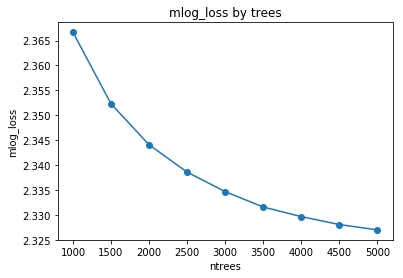

In [9]:
mlog_loss = [2.36666, 2.35231, 2.34410, 2.33861, 2.33469, 2.33161, 2.32968, 2.32809, 2.32701]
ntrees = list(range(1000, 5001, 500))

plt.plot(ntrees, mlog_loss, "o-")
plt.ylabel("mlog_loss")
plt.xlabel("ntrees")
plt.title("mlog_loss by trees")

plt.savefig("../images/xgbclf_bigest_mlog_loss_by_trees.png")
plt.show()

### 3.2 对训练集采样10%的样本进行预测结果分析

In [147]:
data_10000 = datapre.dataset_sample(origin_train_data)

data_10K_X = data_10000[feature_names]
data_10K_y_true = TargetEnc.transform(data_10000["Category"])

In [149]:
a = np.round(xgbclf.predict_proba(data_10K_X), 3)

各个类别的查准率

In [152]:
precision_score(data_10K_y_true, a.argmax(axis=1), average=None)

d:\Anaconda3\envs\gym\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.55555556, 0.22946214, 1.        , 0.        , 0.28396947,
       0.25925926, 0.55555556, 0.35719298, 0.08333333, 0.66666667,
       1.        , 0.5       , 0.31987578, 0.33980583, 0.        ,
       0.        , 0.31820541, 0.46153846, 0.57377049, 0.57037037,
       0.28073927, 0.30974833, 0.        , 0.5487228 , 0.69230769,
       0.35042735, 0.63265306, 0.28571429, 0.66666667, 0.        ,
       0.        , 0.33333333, 0.2173913 , 0.        , 0.39506173,
       0.35282258, 0.31392604, 0.4127907 , 0.70588235])

各个类别的查全率

In [153]:
recall_score(data_10K_y_true, a.argmax(axis=1), average=None)

array([0.03311258, 0.22307492, 0.02439024, 0.        , 0.10119695,
       0.09722222, 0.02202643, 0.47155827, 0.00233645, 0.01709402,
       0.03846154, 0.10204082, 0.09707823, 0.02098321, 0.        ,
       0.        , 0.73602058, 0.09473684, 0.28688525, 0.35552135,
       0.19913326, 0.37747662, 0.        , 0.77540107, 0.02866242,
       0.01782609, 0.31794872, 0.00601202, 0.01366743, 0.        ,
       0.        , 0.01960784, 0.00159185, 0.        , 0.04365621,
       0.03913238, 0.2967646 , 0.01682066, 0.01401869])

#### 分析
样本最多的案件类型为"LARCENY/THEFT"，它的查准率和查全率分别为：0.31820541、0.73602058。查准率仅为31.8%，即约有27582(17490\*0.73602058/0.31820541\*(1-0.31820541))错误分类为"LARCENY/THEFT"，占总样本数的31.4%。
    
 样本的不平衡导致模型预测时倾向于将新样本分配给训练集中样本较多的类别。

准确率

In [160]:
# 准确率
from sklearn.metrics import accuracy_score
accuracy_score(data_10K_y_true, a.argmax(axis=1))

0.3174164019537521

TOP3准确率

In [165]:
good_num=0
for i,v in enumerate(data_10K_y_true):
    if v in np.argsort(a[i])[-3:]:
#         print(v, np.argsort(a[i])[-3:])
        good_num+=1

print(good_num/data_10K_y_true.shape[0])
    

0.5908164543270599


#### 分析
虽然对数损失不高，但是准确率却很低，说明当前训练集的特征的区分度不够高，得到的结果概率比较模棱两可。

## 4 总结

这个多分类问题很有挑战，训练集庞大、特征少、目标分类多、特征之间具有一定关联性都大大增加了问题的难度。

由于数据集太大，如果直接使用整个数据集进行训练和调参需要的时间难以接受，因此用于训练和调参的数据集是从训练集中采样得来，采样过程保证了随机和类别完整。得到合适参数后再使用整个训练集进行一次训练。

我使用网格搜索结合5折交叉验证对随机森林和XGBoost分类器进行调参和优化，最终确认XGBoost分类器更加适合该问题。

在使用XGBoost库过程中发现，虽然该库支持GPU的加速，但是该方式对于小模型、小数据集还可以，当数据集很大、模型很复杂的场景下出现了内存相关的意外情况，导致浪费了大量的训练时间。最终还是采用了CPU训练的方式，效率虽然低但是很稳定。

通过该项目发现自身在独立解决问题时很多弊端：
1. 思路不清晰。拿到问题就开始使用全数据集跑模型，没有进行详细、完整的数据集分析。导致多次跑模型浪费了很多时间。
1. 环境准备。没有实现申请一个高性能的云环境而是在本地搞得，效率很低。
1. 中间数据备份不及时。很多中间数据没有记录，导致写报告时很多分析过程数据都没了。也可以归为思路不清晰范畴。
1. 数据分析、挖掘能力比较弱，不能充分的利用现有数据和统计学工具。